# Recursive Utility: Solution Methods 

------

#### Prepared for the CBC Workshop May 2024
#### John Stachurski

------

## Outline

In some dynamic models, lifetime utility is nonlinear and defined recursively.

*  models with Epstein-Zin preferences
*  risk-sensitive preferences
*  models with ambiguity aversion
*  robust control models
*  adversarial agents

In this lecture we explore how to compute lifetime utility in some of these settings.

Our main focus will be the Epstein-Zin setting.

Uncomment if necessary:

In [1]:
#!pip install quantecon

We will use the following imports.

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
import time
import quantecon as qe

jax.config.update("jax_enable_x64", True)

Looking for a GPU:

In [3]:
!nvidia-smi

Thu May 16 22:00:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:3E:00.0 Off |                  N/A |
| 30%   30C    P3            106W /  320W |       6MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/home/john/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Newton-Kantorovich iteration

Here's a quick reminder on how to use Newton's method in $\mathbb R^n$.

Suppose we have a function $F \colon \mathbb R^n \to \mathbb R^n$ and we seek a $v \in \mathbb R^n$ with $Fv=0$.

Newton's method takes a guess $v_0$ and updates it by

* computing a first order approximation $\hat F$ to $F$ at $v_0$ and
* finding the $v_1$ such that $\hat F(v_1) = 0$.

The process then repeats, now starting from $v_1$, etc.

The first order approximation of $F$ at $v_0$ is

$$
\hat Fv = Fv_0 + J (v - v_0)
$$

where $J$ is the Jacobian of $F$ at $v_0$.

Setting $\hat Fv_1 = 0$ yields $Jv_1 = Jv_0 - Fv_0$.  Rearranging gives

$$
   v_1 = v_0 - J^{-1} F v_0
$$

We use this update rule below.

## Epstein-Zin Model


### The EZ recursion

For Epstein--Zin preferences, lifetime utility from time $t$ onwards is given by

$$
V_t = \left\{
        C_t^\rho + \beta (\mathbb E_t V_{t+1}^\gamma)^{\rho/\gamma} 
      \right\}^{1/\rho}
$$

Here

* $(C_t)$ is a consumption path that is being valued by the agent
* $\beta \in (0,1)$ and $\gamma, \rho$ are nonzero
* $\mathbb E_t$ is time $t$ expectation
* $V_t$ is lifetime utility generated by $C_t, C_{t+1}, C_{t+2}, \ldots$
  
One way to understand the recursion above is to write it as

$$
V_t = \left\{
        C_t^\rho + \beta (\mathcal E_t V_{t+1})^\rho
      \right\}^{1/\rho}
$$

where $\mathcal E$ computes the ``risk-adjusted expectation'' 

$$
\mathcal E Y = (\mathbb E Y^\gamma)^{1/\gamma}
$$

* $\gamma$ governs risk aversion
* $\rho$ governs elasticity of intertemporal substitution

### A Markov Formulation

We suppose $C_t = c(X_t)$ where $X_t$ is a Markov process taking values in state
space $S$.

We guess the solution has the form $V_t = v(X_t)$ for all $t$, where $v$ is some
function over $S$.

In this case we can write the above equation as

$$
v(X_t) = \left\{
        c(X_t)^\rho + \beta (\mathbb E_t v(X_{t+1})^\gamma)^{\rho/\gamma} 
      \right\}^{1/\rho}
$$

Let's suppose that $(X_t)$ is a Markov chain with transition matrix $P$.

It suffices to find a $v \colon S \to \mathbb R$ such that

$$
    v(x) 
    = \left\{
        c(x)^\rho + \beta \left[\sum_{x'} v(x')^\gamma P(x, x')\right]^{\rho/\gamma} 
      \right\}^{1/\rho}
    \qquad (x \in S)
$$


We define the operator $K$ sending $v$ into $Kv$ by

$$
    (Kv)(x) 
    = \left\{
        c(x)^\rho + \beta \left[\sum_{x'} v(x')^\gamma P(x, x')\right]^{\rho/\gamma} 
      \right\}^{1/\rho}
$$

We seek a fixed point of $v$ (i.e., a $v$ with $Kv=v$).

## Solvers

To solve for a fixed point of $K$ we use two methods.

The first is successive approximation (also called fixed point iteration): pick any $v$ and then iterate with $K$.

The second is Newton's method, which is used to find the $v \in \mathbb R^n$ such that $Fv = 0$.

We can use Newton's method to find a fixed point of $K$ by computing a zero of $Fv = Kv - v$.

As discussed above, Newton's method for finding a zero of $F$ is to iterate on

$$
v_{k+1} = v_k - J(v_k)^{-1} F(v_k) 
$$

where $J(v)$ is the Jacobian of $F$ evaluated at $v$.

In general

* Newton's method has a faster rate of convergence (quadratic vs linear)
* Successive approximation is more robust and can be quicker due to smaller constant terms in the rate of convergence.

Here are our two solvers.

In [4]:
def successive_approx(K, v_init, max_iter=50_000, tol=1e-8):
    "Compute the fixed point of K by iterating from guess v_init."
    
    i, error = 0, tol + 1
    v = v_init
    while error > tol and i < max_iter:
        v_new = K(v)
        error = np.max(np.abs(v_new - v))
        i += 1
        v = v_new
    return v, i


def newton_solver(K, v_init, max_iter=10_000, tol=1e-8):
    """
    Apply Newton's algorithm to find a fixed point of K. 

    We use a root-finding operation on F(v) = K(v) - v, which requires 
    iterating with the map 

        Q(v) = v - J(v)^{-1} F(v).

    Here J(v) is the Jacobian of F evaluated at v.

    """
    F = lambda v: K(v) - v
    @jax.jit
    def Q(v):
        J = jax.jacobian(F) 
        return v - jnp.linalg.solve(J(v), F(v))
    return successive_approx(Q, v_init, tol=tol, max_iter=max_iter)

### Solution

In solving the model, we need to specify the function $c$ in $C_t = c(X_t)$ and the state process.

For the state process we use a Tauchen discretization of 

$$
    X_{t+1} = \alpha X_t + \sigma Z_{t+1},
    \qquad \{Z_t\} \text{ is IID and } N(0, 1)
$$

We assume that $c(x) = \exp(x)$.

In [5]:
c = jnp.exp

Here's the model.

In [6]:
Model = namedtuple('Model', ('ρ', 'γ', 'β', 'α', 'σ', 'x_vals', 'c_vals', 'P'))

def create_ez_model(ρ=1.6,
                    γ=-2.0,
                    α=0.9,
                    β=0.998,
                    σ=0.1,
                    n=1_000):
    mc = qe.tauchen(n, α, σ)
    x_vals, P = jnp.exp(mc.state_values), mc.P
    c_vals = c(x_vals)
    P = jnp.array(P)
    return Model(ρ, γ, β, α, σ, x_vals, c_vals, P)

Here's the operator $K$.

In [7]:
@jax.jit
def K(v, model):
    ρ, γ, β, α, σ, x_vals, c_vals, P = model
    return (c_vals**ρ + β * (P @ v**γ)**(ρ / γ))**(1 / ρ)

Let's solve it using the two different solvers and see which is faster.

In [8]:
model = create_ez_model()
ρ, γ, β, α, σ, x_vals, c_vals, P = model
v_init = c_vals

In [9]:
start_time = time.time()
v_sa, num_iter = successive_approx(lambda v: K(v, model), v_init)
sa_time = time.time() - start_time
print(f"Successive approximation converged in {num_iter} iterations.")
print(f"Execution time = {sa_time:.5} seconds.")

Successive approximation converged in 8409 iterations.
Execution time = 2.7868 seconds.


In [10]:
start_time = time.time()
v_newton, num_iter = newton_solver(lambda v: K(v, model), v_init)
newton_time = time.time() - start_time
print(f"Successive approximation converged in {num_iter} iterations.")
print(f"Execution time = {newton_time:.5} seconds.")

Successive approximation converged in 9 iterations.
Execution time = 0.37644 seconds.


In [11]:
print(f"Successive approx time / Newton time = {sa_time / newton_time}")

Successive approx time / Newton time = 7.403116574504105


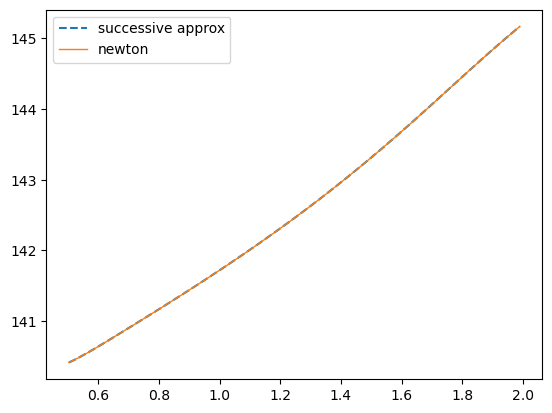

In [12]:
fig, ax = plt.subplots()
ax.plot(x_vals, v_sa, label='successive approx', ls='--')
ax.plot(x_vals, v_newton, lw=1, label='newton')
ax.legend()
plt.show()

## Exercise

Step $\sigma$ through `0.05, 0.075, 0.1, 0.125`, in each case computing the solution and plotting lifetime utility (all on the same figure).

How does increasing volatility affect lifetime utility?

(You might find that lifetime utility goes up with $\sigma$, even though the agent is risk-averse ($\gamma < 0$).  Can you explain this?)

In [13]:
# Put your code here.

In [14]:
for i in range(18):
    print("Solution below! 🐾")

Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾


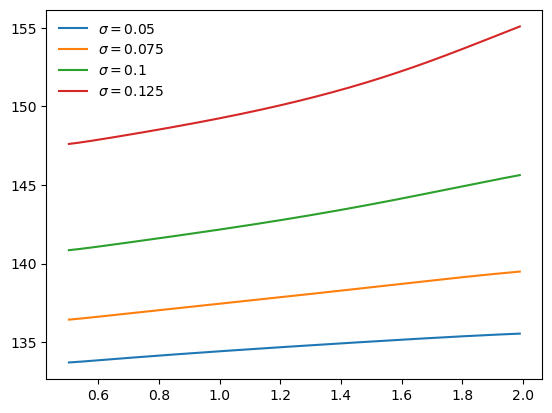

In [15]:
v_init = c_vals
sig_vals = 0.05, 0.075, 0.1, 0.125

fig, ax = plt.subplots()
for σ in sig_vals:
    model= create_ez_model(σ=σ, γ=0.5)
    v, _ = newton_solver(lambda v: K(v, model), v_init)
    v_init = v
    ax.plot(x_vals, v, label=f"$\sigma = {σ:.4}$")
ax.legend(frameon=False)
plt.show()
    